Rooftop Object Detection Using A CNN

1. Installation and Setup


In [ ]:
#Ensure dependencies are compatible versions
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14.0

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!pip install keras==2.2.5
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

TensorFlow 1.x selected.
     |████████████████████████████████| 377.0MB 46kB/s 
     |████████████████████████████████| 491kB 39.5MB/s 
     |████████████████████████████████| 3.2MB 41.7MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
--2020-08-09 14:27:46--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_am

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

1.15.2


'/device:GPU:0'

In [ ]:
#Mount drive containing images and annotations via Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

!ls
%cd gdrive/My Drive/Project 1 #find your desired folder path

#if not already cloned:
#!git clone https://github.com/matterport/Mask_RCNN.git

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb  gdrive  sample_data
/content/gdrive/My Drive/Project 1


In [ ]:
#Navigate to Mask_RCNN folder and run setup
%cd Mask_RCNN
! python setup.py install

/content/gdrive/My Drive/Project 1/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.

2. Importing and Data Preprocessing



In [ ]:
#Define functions for data preprocessing and dataset loading

from os import listdir
from xml.etree import ElementTree
from skimage import color
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from PIL import Image
import os
import argparse
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean

# class that defines and loads the roof dataset
class RoofDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "roof")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/'
		annots_list = os.listdir(annotations_dir)
		images_list = os.listdir(images_dir)
		annots_list = [annot[: -4] for annot in annots_list]
		no_of_files = len(images_list)
		# find all images	
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[18:-8]
			# skip any image file without a corresponding annotation file
			if filename[:-4] not in annots_list:
				continue
			# skip all images after 80% if we are building the train set
			if is_train and int(image_id) >= (no_of_files*0.8):
				continue
			# skip all images before 80% if we are building the test/val set
			if not is_train and int(image_id) < (no_of_files*0.8):
				continue
			# resize to a normal resolution
			size = [800, 600]
			im = Image.open(images_dir+filename)
			im_resized = im.resize(size, Image.ANTIALIAS)
			im_resized.save(images_dir+filename)
			img_path = images_dir + filename
			ann_path = annotations_dir + filename[:-4] + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			# rescale boxes for resized images
			x_scale = 800/4608
			y_scale = 600/3456
			coors_resized = [int(xmin*x_scale), int(ymin*y_scale), int(xmax*x_scale), int(ymax*y_scale)]
			boxes.append(coors_resized)
		# extract image dimensions
		width = 800
		height = 600
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('roof'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

Using TensorFlow backend.


Train: 125
Test: 35


In [ ]:
#Load datasets

# train set
train_set = RoofDataset()
train_set.load_dataset('sequoia-rgb-images', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = RoofDataset()
test_set.load_dataset('sequoia-rgb-images', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

3. Image Analysis

(600, 800, 3)
(600, 800, 2)


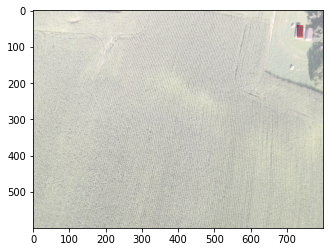

In [ ]:
# load an image
image_id = 2
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='Reds', alpha=0.5)
pyplot.show()

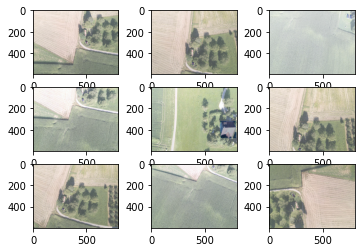

In [ ]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='Blues', alpha=0.3)
# show the figure
pyplot.show()

In [ ]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': '0282', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072753_0282_RGB.JPG', 'annotation': 'sequoia-rgb-images/annotations/IMG_160729_072753_0282_RGB.xml'}
{'id': '0283', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072756_0283_RGB.JPG', 'annotation': 'sequoia-rgb-images/annotations/IMG_160729_072756_0283_RGB.xml'}
{'id': '0279', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072746_0279_RGB.JPG', 'annotation': 'sequoia-rgb-images/annotations/IMG_160729_072746_0279_RGB.xml'}
{'id': '0281', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072751_0281_RGB.JPG', 'annotation': 'sequoia-rgb-images/annotations/IMG_160729_072751_0281_RGB.xml'}
{'id': '0268', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072720_0268_RGB.JPG', 'annotation': 'sequoia-rgb-images/annotations/IMG_160729_072720_0268_RGB.xml'}
{'id': '0252', 'source': 'dataset', 'path': 'sequoia-rgb-images/images/IMG_160729_072

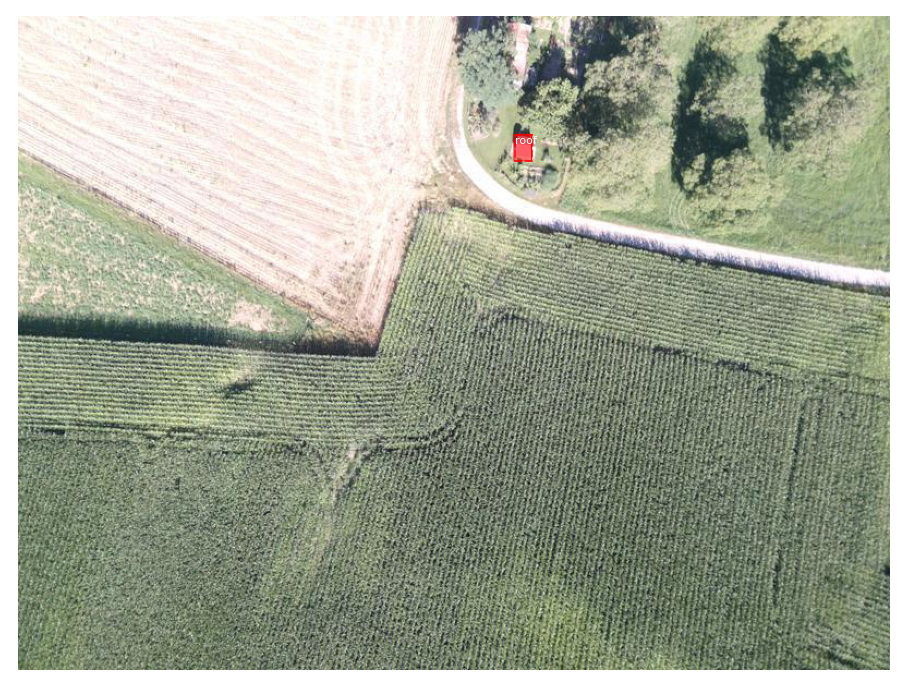

In [ ]:
# define image id
image_id = 3
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

4. Model Training

In [ ]:
# define a configuration for the model
class roofConfig(Config):
	# Give the configuration a recognizable name
	NAME = "roof_cfg"
	# Number of classes (background + roof)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = len(train_set.image_ids)
 
# prepare config
config = roofConfig()
config.display()
epochs = 20

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=epochs, layers='heads')

5. Model Evaluation

In [ ]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "roof_cfg"
	# number of classes (background + roof)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# load trained model weights
model.load_weights('roof_cfg20200712T1441/mask_rcnn_roof_cfg_0020.h5', by_name=True) #edit with latest model weights

def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

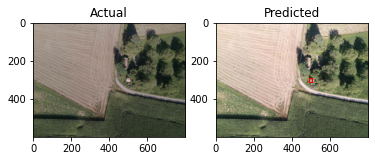

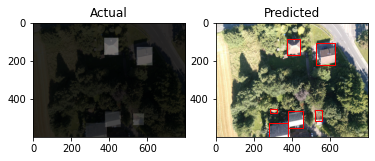

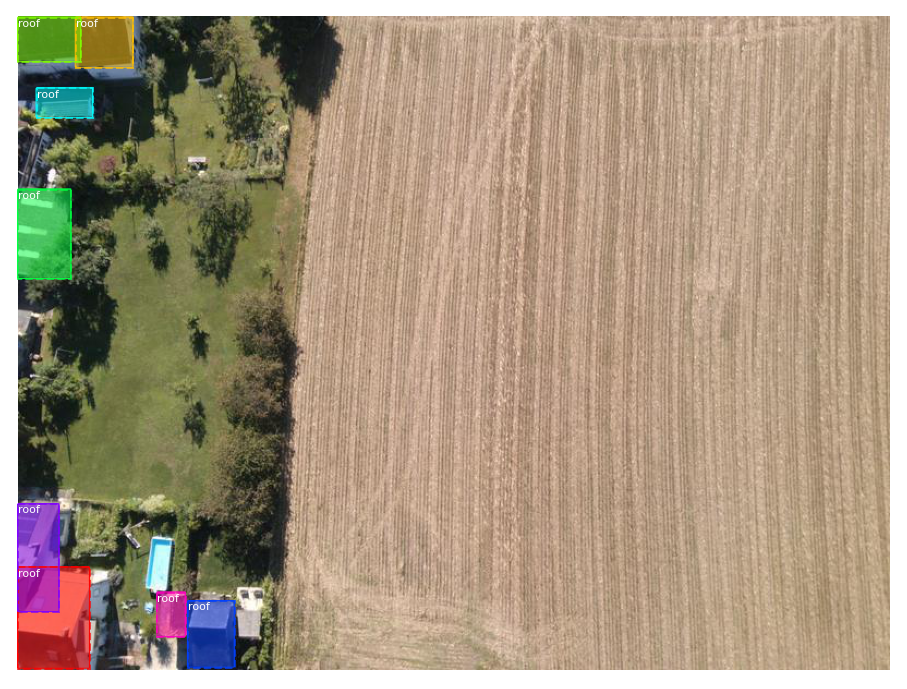

In [ ]:
from matplotlib.patches import Rectangle

# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=1):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()
 
 # plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


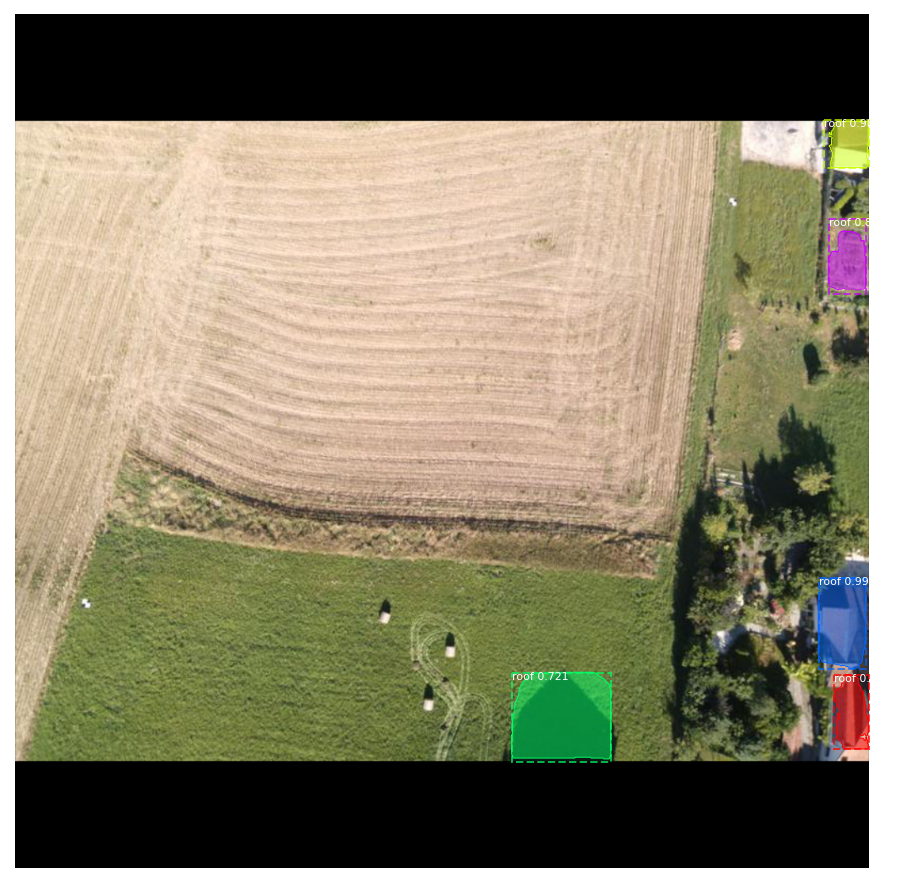

In [ ]:
import random

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = pyplot.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(test_set, cfg, 
                           image_id, use_mini_mask=False)

#log("original_image", original_image)
#log("image_meta", image_meta)
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

r = results[0]
display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=get_ax())
pyplot.savefig('example5.png')

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  218.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   91.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


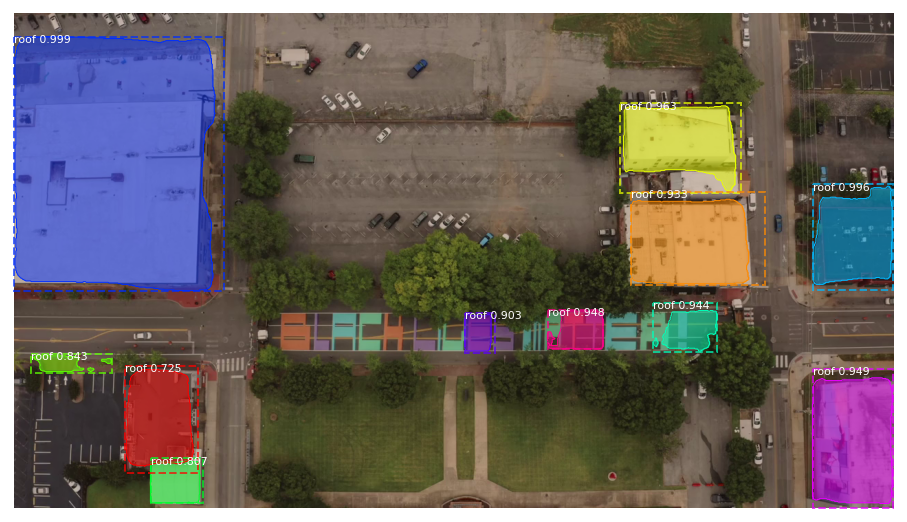

TypeError: ignored

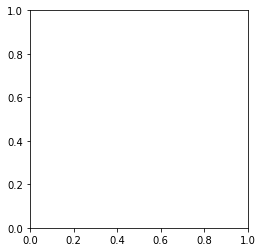

In [ ]:
#Prediction on video
#This code doesn't run, I can't fix it yet

import cv2
import colorsys
import matplotlib
matplotlib.use('TkAgg')
import matplotlib
from google.colab.patches import cv2_imshow


classes = test_set.class_names
hsv = [(i / len(classes), 1, 1.0) for i in range(len(classes))]
colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(colors)

def custom_visualize(test_image, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation):
    detections = model.detect([test_image], verbose=1)[0]

    if mrcnn_visualize:
        matplotlib.use('TkAgg')
        mightnotneed = display_instances(test_image, detections['rois'], detections['masks'], detections['class_ids'],
                                    classes,
                                    detections['scores'])

        return

    if instance_segmentation:
        hsv = [(i / len(detections['rois']), 1, 1.0) for i in range(len(detections['rois']))]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.seed(42)
        random.shuffle(colors)

    for i in range(0, detections["rois"].shape[0]):
        classID = detections["class_ids"][i]

        mask = detections["masks"][:, :, i]
        if instance_segmentation:
            color = colors[i][::-1]
        else:
            color = colors[classID][::-1]

        # To visualize the pixel-wise mask of the object
        #test_image = visualize.apply_mask(test_image, mask, color, alpha=0.5)

    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)

    if draw_bbox=='True':
        for i in range(0, len(detections["scores"])):
            (startY, startX, endY, endX) = detections["rois"][i]

            classID = detections["class_ids"][i]
            label = classes[classID]
            score = detections["scores"][i]

            if instance_segmentation:
                color = [int(c) for c in np.array(colors[i]) * 255]

            else:
                color = [int(c) for c in np.array(colors[classID]) * 255]

            cv2.rectangle(test_image, (startX, startY), (endX, endY), color, 2)
            text = "{}: {:.2f}".format(label, score)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(test_image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    #return test_image


def perform_inference_video(video_path, model, colors, classes, draw_bbox, mrcnn_visualize,
                            instance_segmentation, save_enable):

    video = cv2.VideoCapture(video_path)
    video_flag = True
    res=(360,240) #resolution
    out = cv2.VideoWriter("Result_Video.mp4", cv2.VideoWriter_fourcc(*'MP4V'), 8,
                      res)
    while True:
        ret, frame = video.read()

        if save_enable and video_flag:

            video_flag = False

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        output = custom_visualize(frame, model, colors, classes, draw_bbox, mrcnn_visualize, instance_segmentation)

        cv2_imshow(output)

        if save_enable:
            out.write(output)

        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break
        
        out.release()

    video.release()

video_output = perform_inference_video('test_video2.mp4', model, colors, classes, draw_bbox=True, mrcnn_visualize=True, instance_segmentation=False, save_enable=True)